# Packages and OS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# generic packages
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm.auto import tqdm
from datetime import datetime
import pandas as pd

# # os directory
YOUR_FOLDER_DIRECTORY = os.getcwd()

# Assuming 'src' directory is located one level above the notebook directory
project_directory = os.path.join(YOUR_FOLDER_DIRECTORY, '..')
sys.path.append(project_directory)

# src code
from src.portfolio_class_240309 import Portfolio
from src.config import (
    TICKERS,
    START_DATE,
    END_DATE,
    INTERVAL,
    RISK_FREE_RATE,
    MSCI_SCORE_ALREADY_DOWNLOADED,
    FREQUENCY_RETURNS
)
from src.backtesting_score import (
    get_last_esg_scores,
    get_first_date_with_all_msci_score_available
)

# scraper code
from exploration.scrapper.scraper import (
    download_msci_esg_ratings_htmlfile,
    load_dict_from_json
)


# Download MSCI data

In [3]:
if MSCI_SCORE_ALREADY_DOWNLOADED:
    # load data
    msci_score = load_dict_from_json("../data/exemple_msci_esg_ratings_numeric.json")
else:
    # scrap data
    msci_score={}
    for ticker in tqdm(TICKERS):
        dict = download_msci_esg_ratings_htmlfile(tickers=[ticker])
        msci_score[ticker] = dict[ticker]

    for ticker in msci_score.keys():
        for key, rating in msci_score[ticker]['esg_score_dict'].items():
            key = datetime.strptime(key, '%b-%y').strftime('%Y-%m-%d')
    # # save data
    # from src.config import save_dict_to_json
    # save_dict_to_json(msci_score, "../data/exemple_msci_esg_ratings_numeric.json")
    # MSCI_SCORE_ALREADY_DOWNLOADED=True


# 1. Get optimal weights under constraints

In [4]:
END_DATE = '2022-12-01'

if datetime.strptime(END_DATE, '%Y-%m-%d') < get_first_date_with_all_msci_score_available(msci_score):
    print("ERROR: END_DATE is before the first date with all msci score available.")
    END_DATE = get_first_date_with_all_msci_score_available(msci_score)
    print(f"END_DATE is now {END_DATE}, but you can change it.")
else:
    print("Thanks for having entered a valid end date !")

Thanks for having entered a valid end date !


In [5]:
msci_last_esg_score = get_last_esg_scores(msci_score, END_DATE)

PORTFOLIO = Portfolio(TICKERS,
                      START_DATE,
                      END_DATE,
                      INTERVAL,
                      msci_last_esg_score,
                      FREQUENCY_RETURNS)

PORTFOLIO.download_data()

[*********************100%%**********************]  31 of 31 completed


In [6]:
MAX_ESG_SCORE = 60
MAX_ESG_SCORES = list(np.linspace(np.min(msci_last_esg_score), np.max(msci_last_esg_score), 30))
GAMMA_VALUES = np.linspace(-5, 5, 100)  # Inverse of the risk aversion parameter


## 1.1. Market optimum

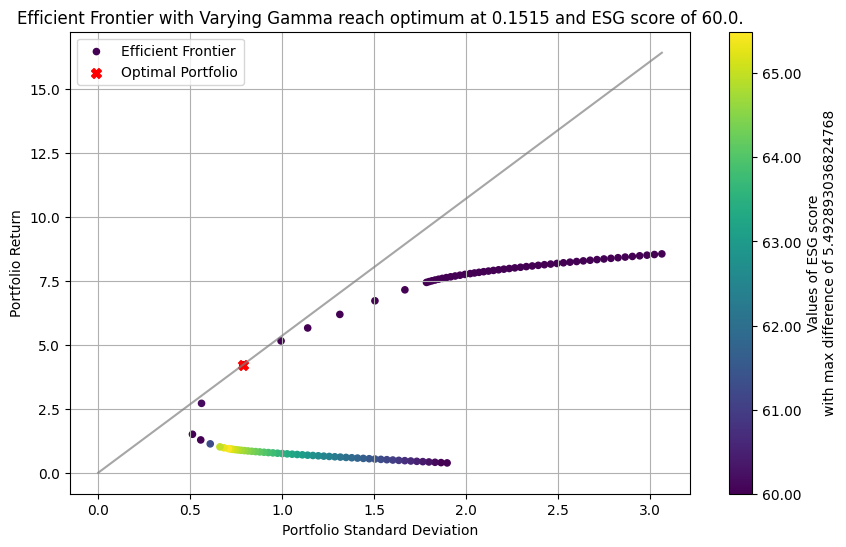

In [7]:
PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=MAX_ESG_SCORE,
                                  fully_invested=True,
                                  long_only=True)


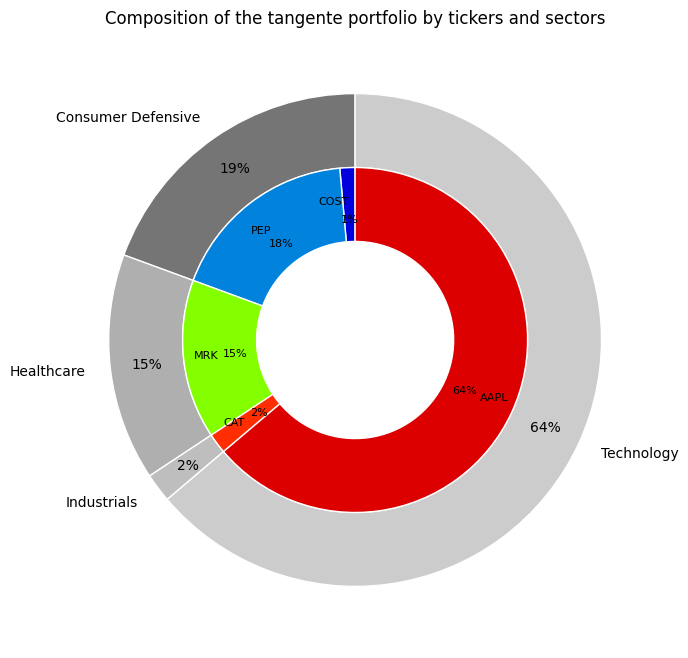

In [8]:
PORTFOLIO.plot_tangente_portfolio_composition(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=MAX_ESG_SCORE,
                                  fully_invested=True,
                                  long_only=True)

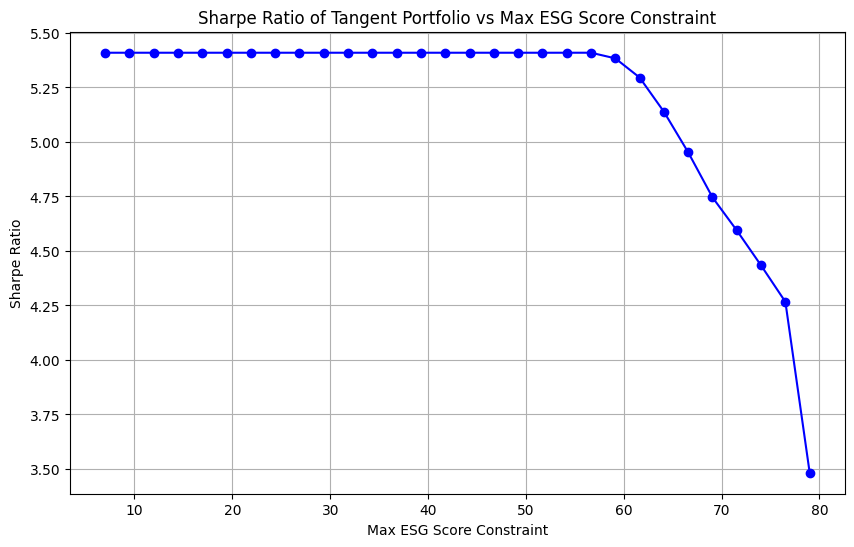

In [9]:
PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=1,
                                        best_in_class_strategy='global')


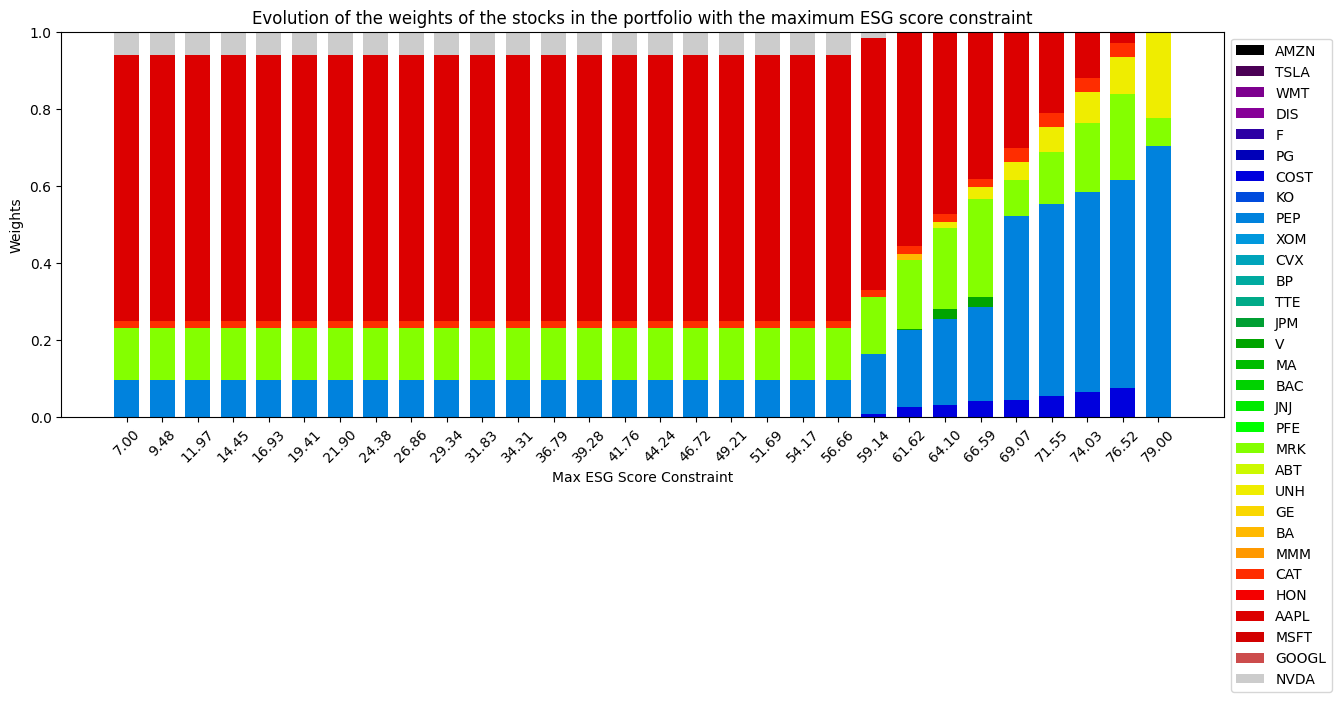

In [10]:
PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
                                 risk_free_rate=RISK_FREE_RATE,
                                 max_esg_scores=MAX_ESG_SCORES,
                                 fully_invested=True,
                                 long_only=True, 
                                 best_in_class_method=1,
                                 best_in_class_strategy='global')

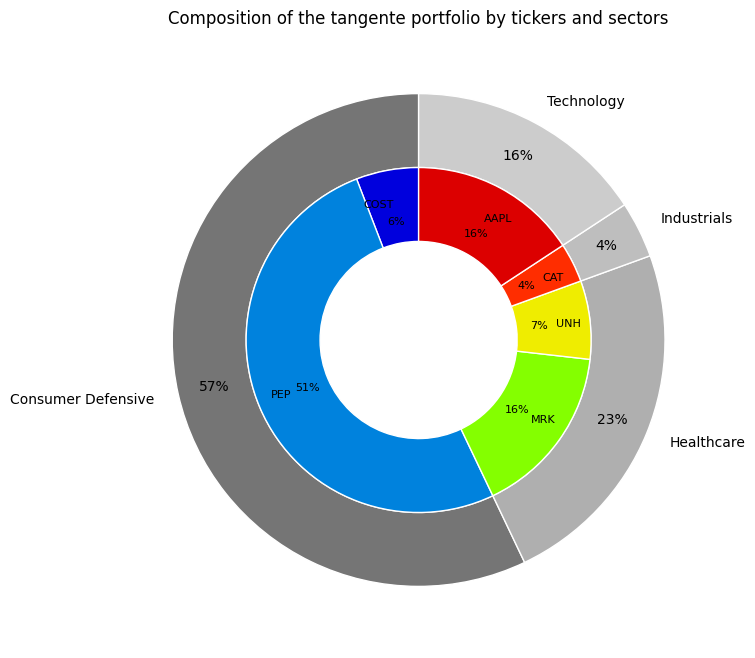

In [11]:
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=1,
                                            best_in_class_strategy='global')

## 1.2. Selection 50% best global scale

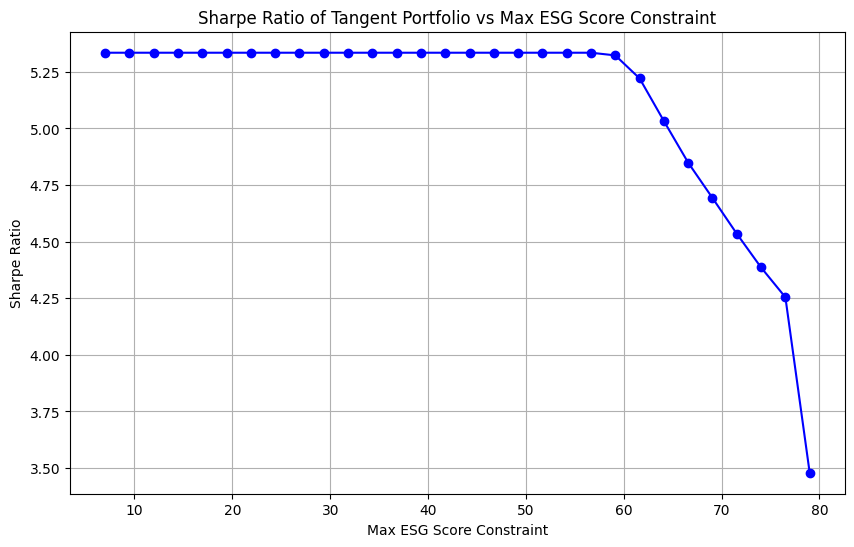

In [12]:
PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=0.5,
                                        best_in_class_strategy='global')


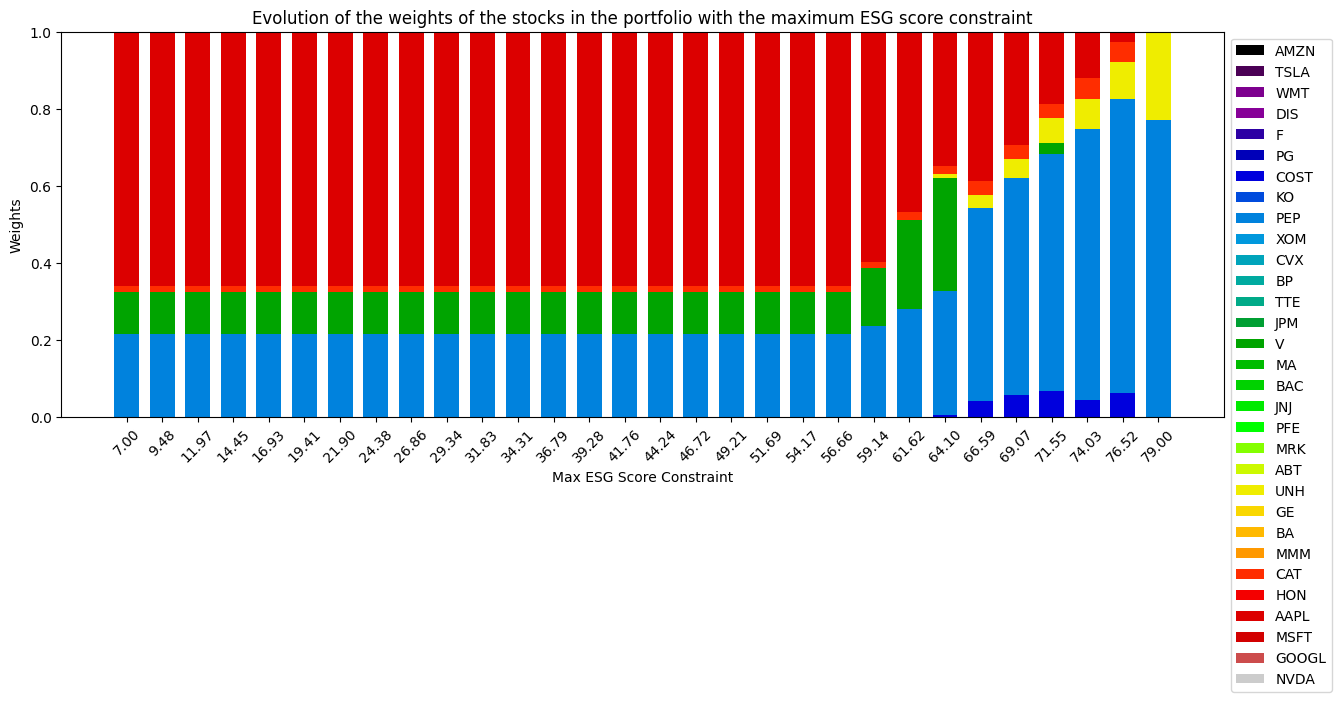

In [13]:
PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
                                 risk_free_rate=RISK_FREE_RATE,
                                 max_esg_scores=MAX_ESG_SCORES,
                                 fully_invested=True,
                                 long_only=True, 
                                 best_in_class_method=0.5,
                                 best_in_class_strategy='global')

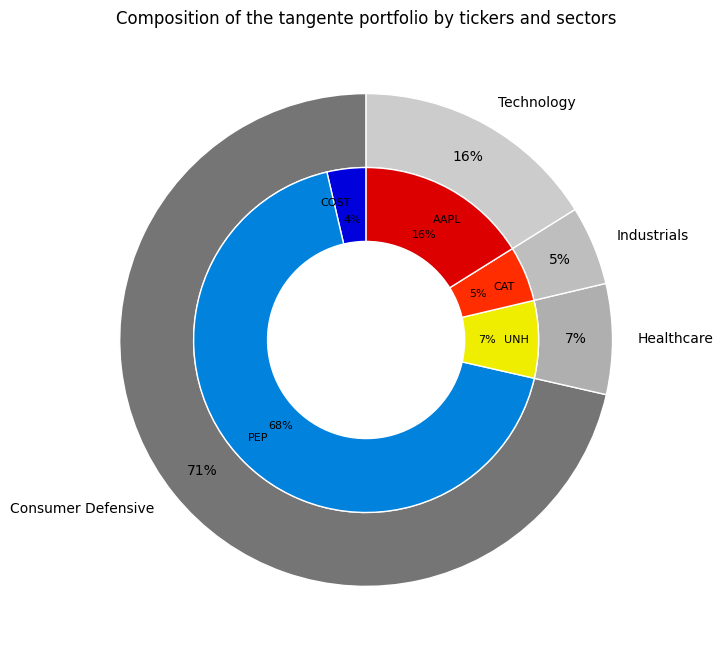

In [14]:
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='global')


## 1.3. Selection 50% best sector scale

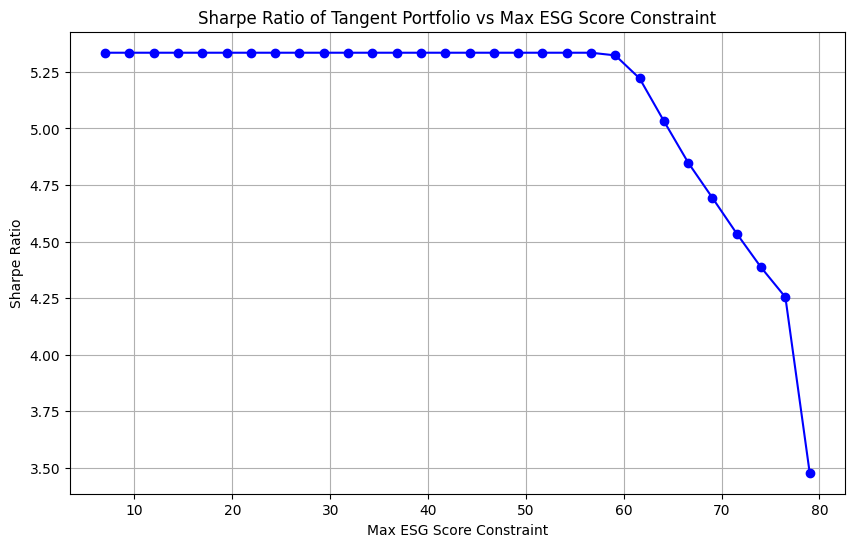

In [15]:
PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=0.5,
                                        best_in_class_strategy='sector')


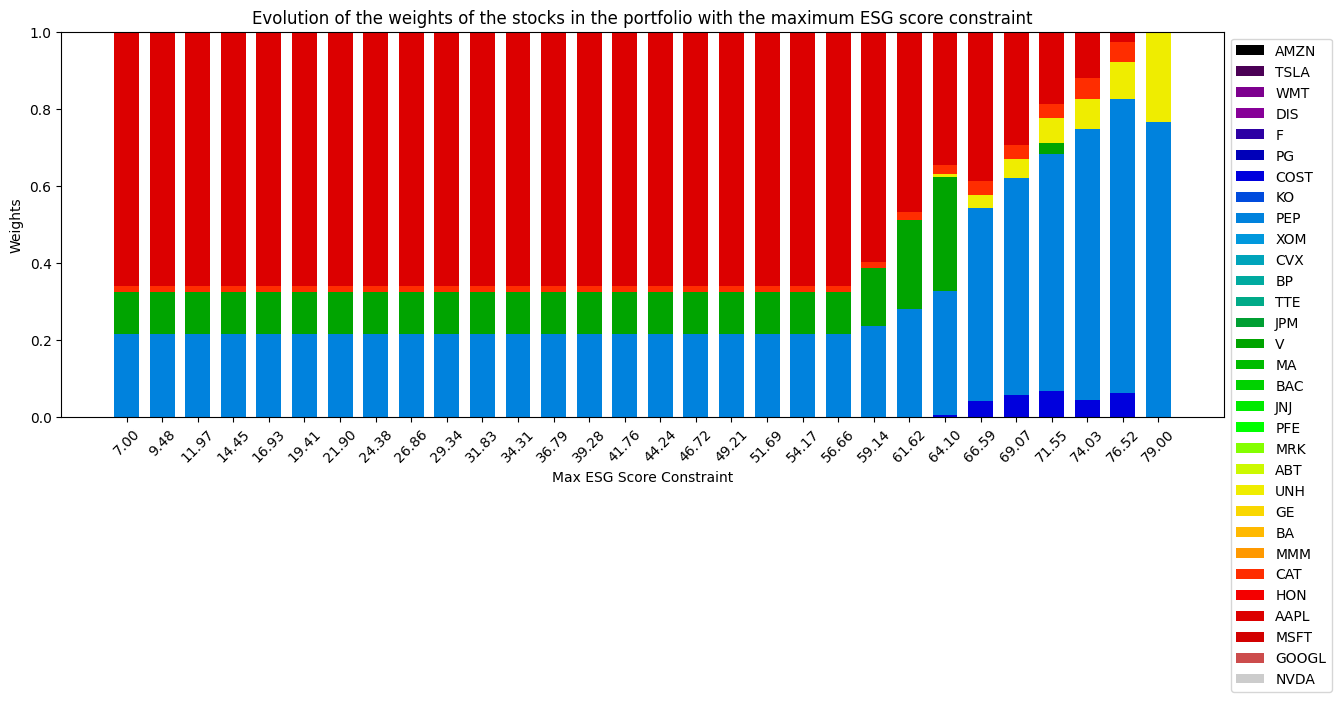

In [16]:
PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
                                 risk_free_rate=RISK_FREE_RATE,
                                 max_esg_scores=MAX_ESG_SCORES,
                                 fully_invested=True,
                                 long_only=True, 
                                 best_in_class_method=0.5,
                                 best_in_class_strategy='sector')

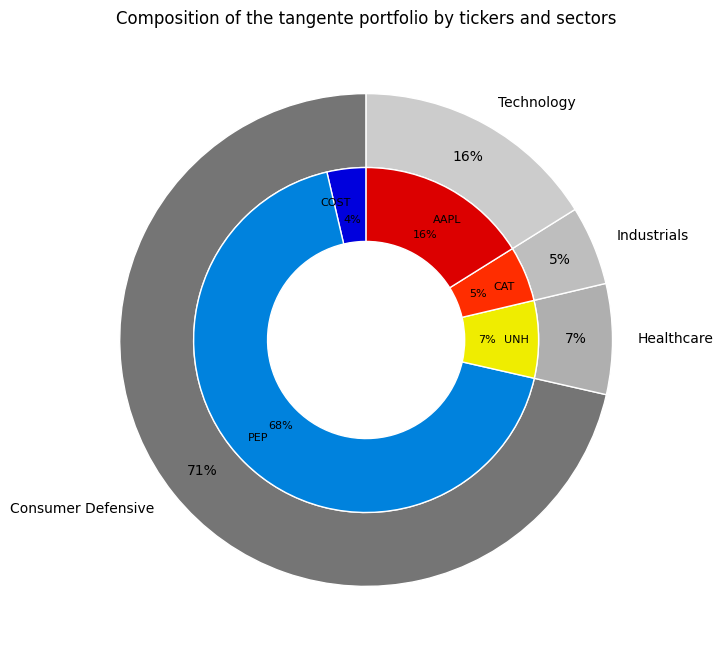

In [17]:
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='sector')


## 1.4. Fixing lower bound on investment per sector

In [18]:
# Ne devrait pas marcher 
# SECTOR_MIN_WEIGHT_X_DICT_EQUAL_WEIGHTED = {sector_name: len(set(PORTFOLIO.get_sector_for_tickers().values())) 
#                                            for sector_name in set(PORTFOLIO.get_sector_for_tickers().values())}

SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS = {'Communication Services': 0.1,
                                      'Consumer Cyclical': 0,
                                      'Consumer Defensive': 0,
                                      'Energy': 0.3,
                                      'Financial Services': 0,
                                      'Healthcare': 0,
                                      'Industrials': 0,
                                      'Technology': 0}


### 1.4.1. Lower bound - Market optimum

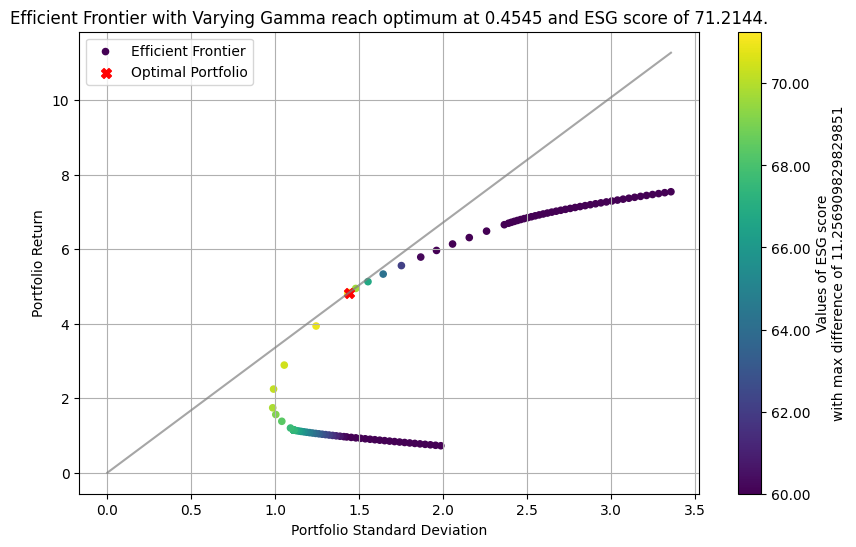

In [19]:
PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=MAX_ESG_SCORE,
                                  fully_invested=True,
                                  long_only=True,
                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

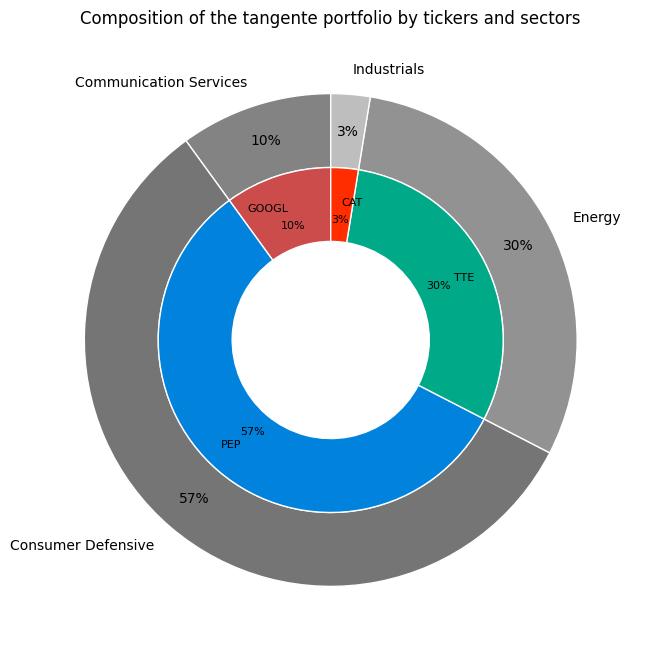

In [20]:
PORTFOLIO.plot_tangente_portfolio_composition(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=MAX_ESG_SCORE,
                                  fully_invested=True,
                                  long_only=True,
                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

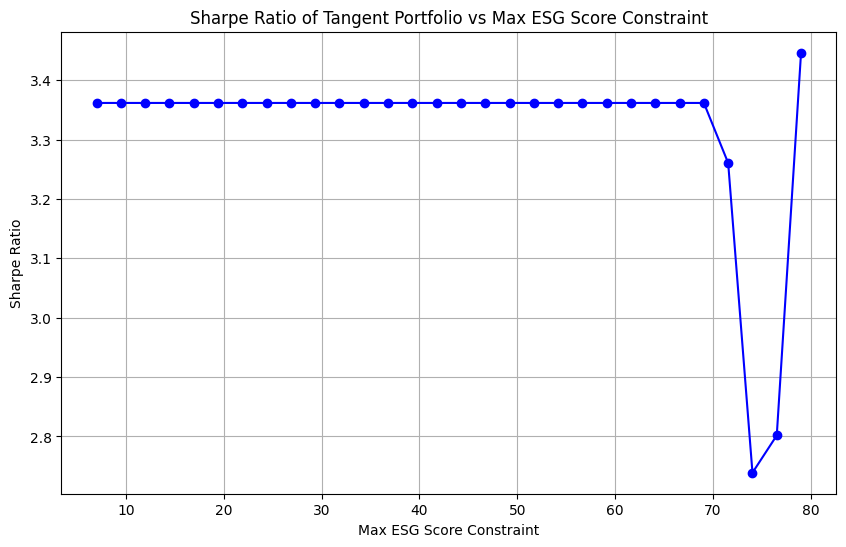

In [21]:
PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=1,
                                        best_in_class_strategy='global',
                                        sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


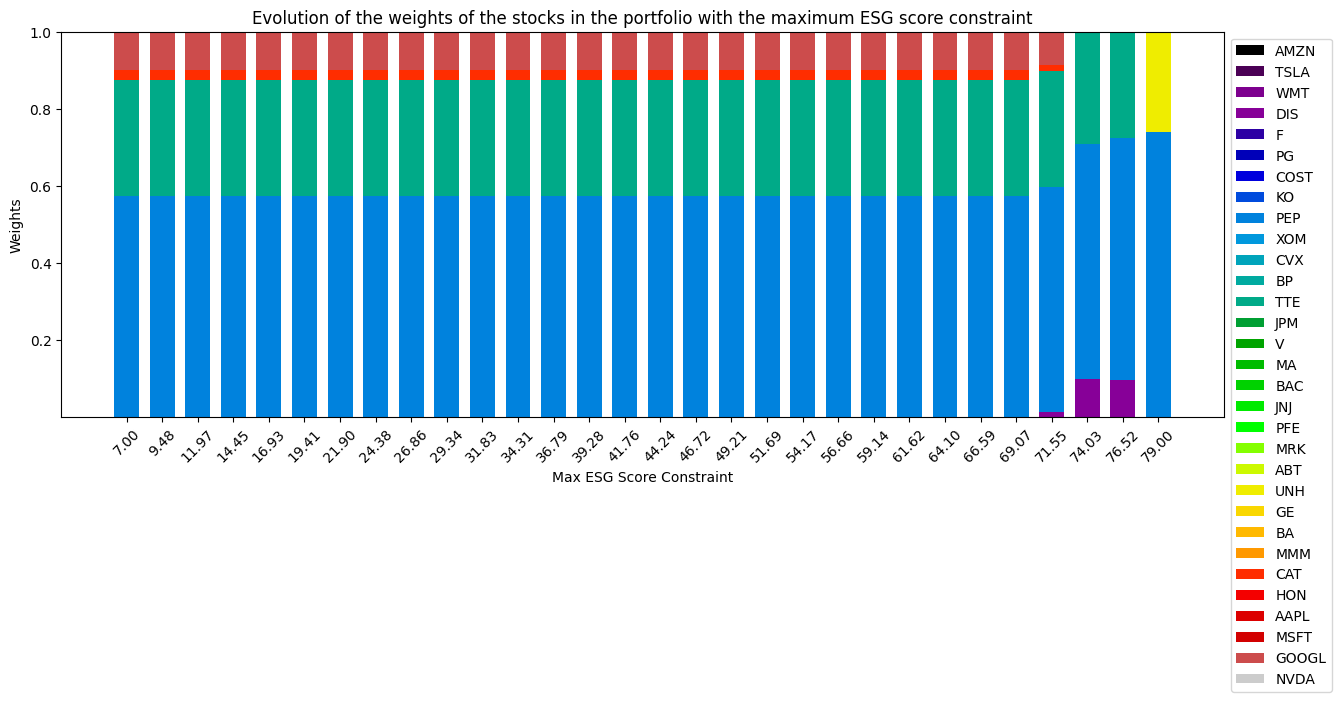

In [22]:
PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
                                 risk_free_rate=RISK_FREE_RATE,
                                 max_esg_scores=MAX_ESG_SCORES,
                                 fully_invested=True,
                                 long_only=True, 
                                 best_in_class_method=1,
                                 best_in_class_strategy='global',
                                 sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


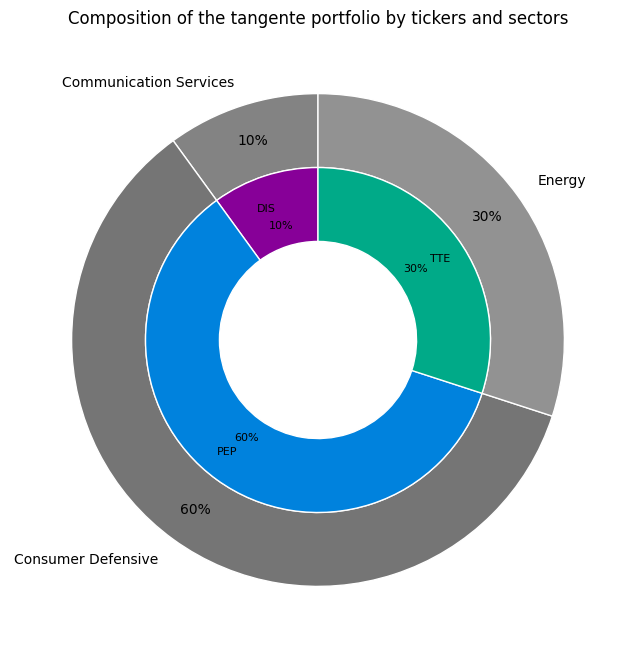

In [23]:
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=1,
                                            best_in_class_strategy='global',
                                            sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

### 1.4.2. Lower bound - 50% sector

In [24]:
PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=0.5,
                                        best_in_class_strategy='sector',
                                        sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)



Error processing AMZN: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v10/finance/quoteSummary/AMZN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&ssl=true&crumb=5Ns0WcDeMct (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x1263cc5b0>: Failed to resolve 'query2.finance.yahoo.com' ([Errno 8] nodename nor servname provided, or not known)"))
Error processing TSLA: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Max retries exceeded with url: /v10/finance/quoteSummary/TSLA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&ssl=true&crumb=5Ns0WcDeMct (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x12a85b970>: Failed to resolve 'query2.finance.yahoo.com' ([Errno 8] nodename nor servname provided, or not known)"))
Error processing WMT: HTTPSConnectionPool(host='query2.finance.yahoo.com', por

KeyError: None

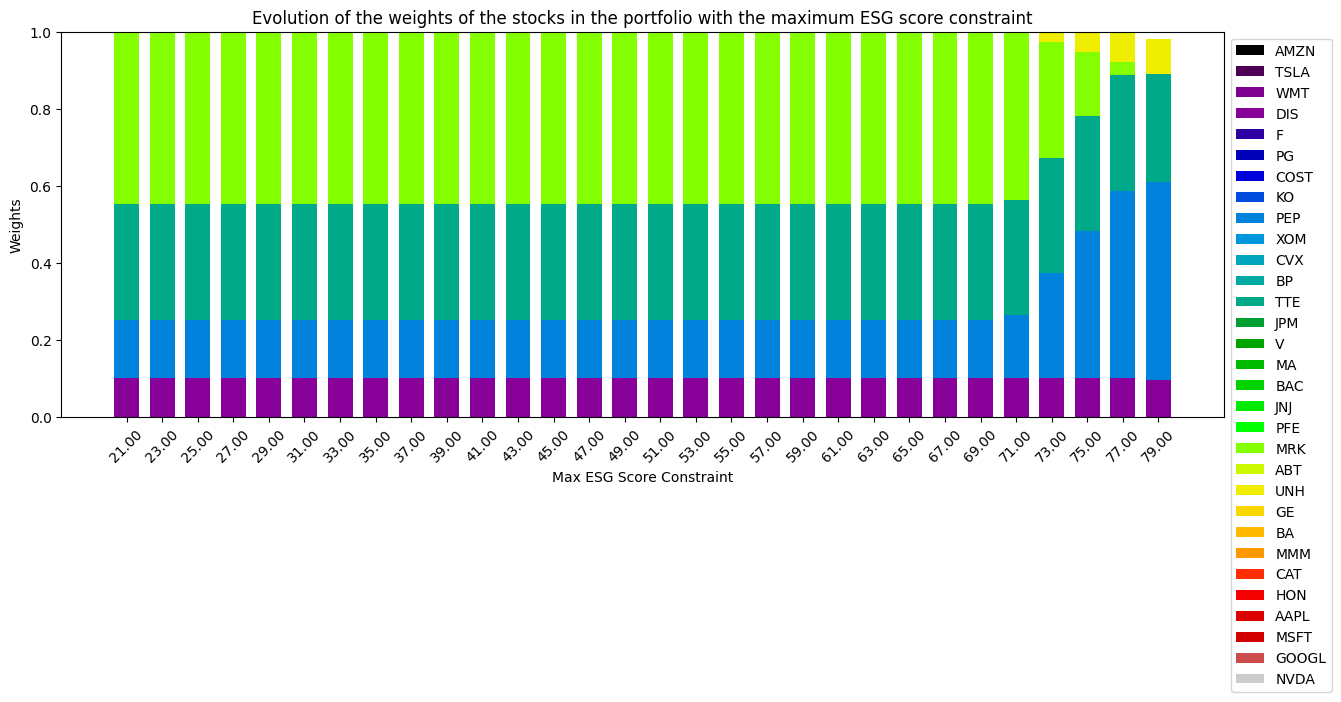

In [ ]:
PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
                                 risk_free_rate=RISK_FREE_RATE,
                                 max_esg_scores=MAX_ESG_SCORES,
                                 fully_invested=True,
                                 long_only=True, 
                                 best_in_class_method=0.5,
                                 best_in_class_strategy='sector',
                                 sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


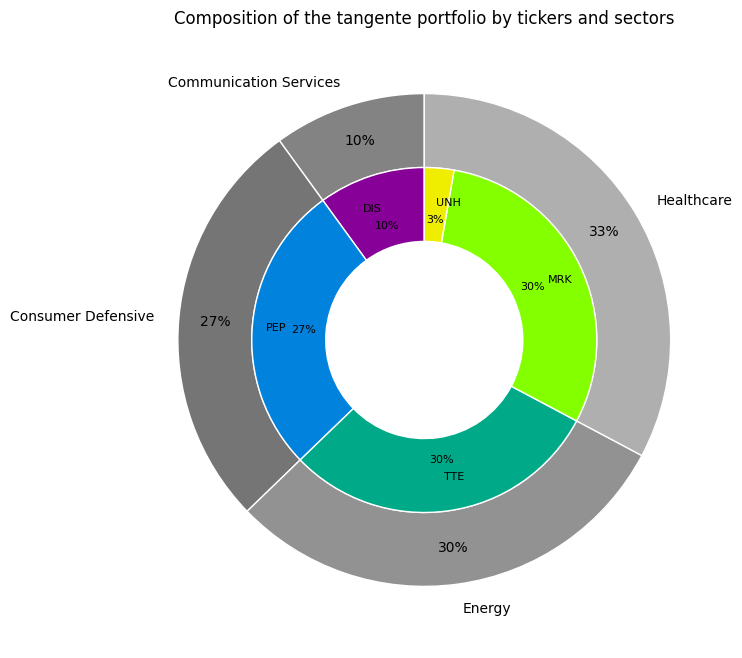

In [ ]:
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='sector',
                                            sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

# 2. Test portfolio performance on unseen data

In [ ]:
def check_if_dates_are_correct(T0, T1, T2):
    if datetime.strptime(T1, '%Y-%m-%d') < get_first_date_with_all_msci_score_available(msci_score):
        print("ERROR: END_DATE is before the first date with all msci score available.")
        T1 = get_first_date_with_all_msci_score_available(msci_score)
        print(f"T1 is now {T1}, but you can change it.")
    else:
        print("Thanks for having entered a valid end date !")


def get_tangente_ptf_weights(T0, 
                             T1,
                             msci_score, 
                             TICKERS, 
                             INTERVAL, 
                             RISK_FREE_RATE, 
                             FREQUENCY_RETURNS, 
                             GAMMA_VALUES, 
                             min_esg_score,
                             fully_invested=True,
                             long_only=True,
                             best_in_class_method=1,
                             best_in_class_strategy='global',
                             sector_min_weight_x_dict=None):

    msci_last_esg_score = get_last_esg_scores(msci_score, T1)

    PTF = Portfolio(tickers=TICKERS,
                    start_date=T0,
                    end_date=T1,
                    interval=INTERVAL,
                    msci_data=msci_last_esg_score,
                    frequency_returns=FREQUENCY_RETURNS)
    
    PTF.download_data()

    PTF.get_optimal_portfolio_markowitz(gammas=GAMMA_VALUES, 
                                                  risk_free_rate=RISK_FREE_RATE,
                                                  max_esg_score=min_esg_score,
                                                  fully_invested=fully_invested,
                                                  long_only=long_only,
                                                  best_in_class_method=best_in_class_method,
                                                  best_in_class_strategy=best_in_class_strategy,
                                                  sector_min_weight_x_dict=sector_min_weight_x_dict)
    
    weights = PTF.weights_tangente_portfolio
    esg_score_tangent = PTF.score_esg_tangent
    

    return weights, esg_score_tangent

def test_tangente_ptf_weights(weights,
                              T1_bis,
                              T2,
                              msci_score,
                              TICKERS,
                              INTERVAL,
                              FREQUENCY_RETURNS):
    
    msci_last_esg_score = get_last_esg_scores(msci_score, T2)

    PTF = Portfolio(tickers=TICKERS,
                    start_date=T1_bis,
                    end_date=T2,
                    interval=INTERVAL,
                    msci_data=msci_last_esg_score,
                    frequency_returns=FREQUENCY_RETURNS)
    
    PTF.get_net_returns()

    return weights, PTF.net_returns, msci_last_esg_score


def get_tangent_ptf_evolution(T0, 
                              T1, 
                              T1_bis,
                              T2, 
                              msci_score, 
                              TICKERS, 
                              INTERVAL, 
                              RISK_FREE_RATE, 
                              FREQUENCY_RETURNS, 
                              GAMMA_VALUES, 
                              min_esg_score,
                              fully_invested=True,
                              long_only=True,
                              best_in_class_method=1,
                              best_in_class_strategy='global',
                              sector_min_weight_x_dict=None,
                              initial_value=None):
    
    weights, esg_score_tangent = get_tangente_ptf_weights(T0, 
                             T1,
                             msci_score, 
                             TICKERS, 
                             INTERVAL, 
                             RISK_FREE_RATE, 
                             FREQUENCY_RETURNS, 
                             GAMMA_VALUES, 
                             min_esg_score,
                             fully_invested,
                             long_only,
                             best_in_class_method,
                             best_in_class_strategy,
                             sector_min_weight_x_dict)
    
    weights, net_returns, msci_last_esg_score = test_tangente_ptf_weights(weights,
                                                                      T1_bis,
                                                                      T2,
                                                                      msci_score,
                                                                      TICKERS,
                                                                      INTERVAL,
                                                                      FREQUENCY_RETURNS)
                              


    # Calculate weighted returns
    weighted_returns = net_returns.dot(weights)

    # Calculate portfolio value
    portfolio_return = (1 + weighted_returns).prod()

    if initial_value is not None:
        portfolio_value = initial_value * portfolio_return
        print("Portfolio value:", portfolio_value)

    print("Portfolio return:", round(portfolio_return, 2))
    print("Portfolio esg score at T1:", esg_score_tangent)
    print("Portfolio esg score at T2:", np.array(msci_last_esg_score) @ weights)


In [ ]:
T0='2020-01-01'
T1='2022-12-01'
T1_bis='2022-01-01'
T2='2023-12-01'

check_if_dates_are_correct(T0, T1, T2)

Thanks for having entered a valid end date !


In [ ]:
get_tangent_ptf_evolution(T0, 
                              T1, 
                              T1_bis,
                              T2, 
                              msci_score, 
                              TICKERS, 
                              INTERVAL, 
                              RISK_FREE_RATE, 
                              FREQUENCY_RETURNS, 
                              GAMMA_VALUES, 
                              min_esg_score=70,
                              fully_invested=True,
                              long_only=True,
                              best_in_class_method=1,
                              best_in_class_strategy='global',
                              sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS,
                              initial_value=100)

[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio value: 2765.403620838904
Portfolio return: 27.65
Portfolio esg score at T1: 71.21426193521177
Portfolio esg score at T2: 75.71426193521117


In [ ]:
for max_score in list(np.linspace(65, np.max(msci_last_esg_score), 15)):
    print(f"Max score: {max_score}")
    get_tangent_ptf_evolution(T0, 
                            T1, 
                            T1_bis,
                            T2, 
                            msci_score, 
                            TICKERS, 
                            INTERVAL, 
                            RISK_FREE_RATE, 
                            FREQUENCY_RETURNS, 
                            GAMMA_VALUES, 
                            min_esg_score=max_score,
                            fully_invested=True,
                            long_only=True,
                            best_in_class_method=1,
                            best_in_class_strategy='global',
                            sector_min_weight_x_dict=None)

Max score: 65.0
[*****                 10%%                      ]  3 of 31 completed

[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio return: 124.02
Portfolio esg score at T1: 65.00000000000006
Portfolio esg score at T2: 61.50353391342911
Max score: 66.0
[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio return: 410.54
Portfolio esg score at T1: 66.0000000000001
Portfolio esg score at T2: 62.21520073887083
Max score: 67.0
[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio return: 1187.03
Portfolio esg score at T1: 67.00000000000004
Portfolio esg score at T2: 62.919425693471794
Max score: 68.0
[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio return: 65.55
Portfolio esg 

In [ ]:
# get weights of tangent portfolio under desired constraints
# test allocation return, vol, (sharp ratio) and esg score Y months later

In [ ]:
#TODO

#2. Backtest analyses
# train l'optimisation entre T0 et T1 -> renvoie des weights
# test les weights sur la période T1 et T2 -> renvoie un score de performance + analyse de si on respecte encore les contraintes esg en T2 (moyenne, variance etc.)
# faire cela pour les différents cas précédement identifiés (1 global, 0.5 global, 0.5 local ET ajout ou non de contraintes sectorielles)

#3. comparer à Sustainalytics ajrd (interval de confiance sur le score ESG?)

# Récap: vérifier les contraintes au cours du temps (les plots) et comparer à des indices ou des ptf equal weights.
# Répéter l'allocation chaque année et comparer comment la frontière efficiente évolue au cours du temps